## Preparing Datasets

In [ ]:
# milk = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv',
#             index_col='Month', parse_dates=True)
# milk.columns = ['production']
# milk.index.name = 'month'
# milk.to_csv('../../datasets/Ch9/milk_production.csv')

# file = Path('../../datasets/Ch8/air_passenger.csv')
# df = pd.read_csv(file, index_col='date', parse_dates=True)
# df.to_csv('../../datasets/Ch9/air_passenger.csv')


# weather = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/nz_weather.csv',
#                      index_col='DATE', parse_dates=True)
# weather.to_csv('../../datasets/Ch9/weather.csv')

# pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv', index_col='date', parse_dates=True).to_csv('../../datasets/Ch9/covid.csv')

# Smoothing Time Series Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tools.eval_measures import rmspe, rmse, aic, bic
from sklearn.metrics import mean_absolute_percentage_error as mape
plt.rcParams["figure.figsize"] = [12, 6]

In [2]:
file = Path('../../datasets/Ch9/milk_production.csv')
milk = pd.read_csv(file, 
                   index_col='month', 
                   parse_dates=True)

In [3]:
milk.shape

(168, 1)

In [4]:
milk.head()

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [5]:
milk.tail()

,production
month,
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797
1975-12-01,843


<AxesSubplot:xlabel='month'>

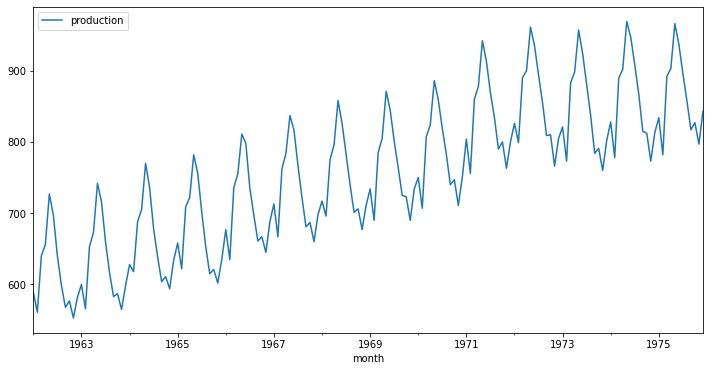

In [6]:
milk.plot()

In [7]:
x_train = milk.iloc[:-12]
x_test = milk.iloc[-12:]
print(x_train.shape[0],
     x_test.shape[0])

156 12


## Single Exponential Smoothing

In [8]:
alphas = np.linspace(0.0, 1.0, 21)
results = {}
for alpha in alphas:
    alpha = round(alpha,2)
    ses = SimpleExpSmoothing(x_train['production'].values,
                            initialization_method='estimated').fit(
                             smoothing_level=alpha,
                             optimized=False)
    forecast  = ses.forecast(12)
    forecast = forecast.reshape(-1,1)
    score = {'rmspe': rmspe(x_test.values, forecast), 
             'rmse':rmse(x_test.values, forecast),
            'mape': mape(x_test.values, forecast),
            'aic': ses.aic, 
            'bic': ses.bic}
    
             
    results[alpha] = (ses,forecast, score)

In [9]:
initial_score = results[0][2]['mape']
best_alpha = 0
for k,v in results.items():
    if v[2]['mape'] < initial_score:
        initial_score = v[2]['mape']
        best_alpha = k
    print(f'for alpha={k} RMSPE={v[2]["rmspe"]} RMSE={v[2]["rmse"]} MAPE={v[2]["mape"]} BIC={v[2]["bic"]}')
print(f'Best alpha: {best_alpha} with lowest MAPE score: {initial_score}')

for alpha=0.0 RMSPE=[2.62971886] RMSE=[232.27097681] MAPE=0.2589537678897573 BIC=1569.941430058617
for alpha=0.05 RMSPE=[0.64523399] RMSE=[58.79252278] MAPE=0.05237978970865403 BIC=1325.6941731853285
for alpha=0.1 RMSPE=[0.63050191] RMSE=[57.02407667] MAPE=0.052058994164454864 BIC=1304.4633253108248
for alpha=0.15 RMSPE=[0.64055462] RMSE=[58.25348] MAPE=0.05218593873256858 BIC=1299.7828400913638
for alpha=0.2 RMSPE=[0.66003037] RMSE=[60.41719003] MAPE=0.0529109628117193 BIC=1296.378858166979
for alpha=0.25 RMSPE=[0.68771145] RMSE=[63.27043501] MAPE=0.0545241127546493 BIC=1291.9174071251598
for alpha=0.3 RMSPE=[0.72064758] RMSE=[66.49878205] MAPE=0.057084832861440254 BIC=1286.0322694188244
for alpha=0.35 RMSPE=[0.75472802] RMSE=[69.73212624] MAPE=0.059954767485075555 BIC=1278.8895441431312
for alpha=0.4 RMSPE=[0.78622412] RMSE=[72.6584988] MAPE=0.06294317703324548 BIC=1270.8288085825714
for alpha=0.45 RMSPE=[0.81264717] RMSE=[75.08101809] MAPE=0.06558580143982731 BIC=1262.2264707266256


In [10]:
results[best_alpha][0].summary()

Dep. Variable:,endog,No. Observations:,156
Model:,SimpleExpSmoothing,SSE,625970.583
Optimized:,False,AIC,1298.364
Trend:,None,BIC,1304.463
Seasonal:,None,AICC,1298.629
Seasonal Periods:,None,Date:,"Tue, 07 Dec 2021"
Box-Cox:,False,Time:,01:04:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
initial_level,636.80000,l.0,False


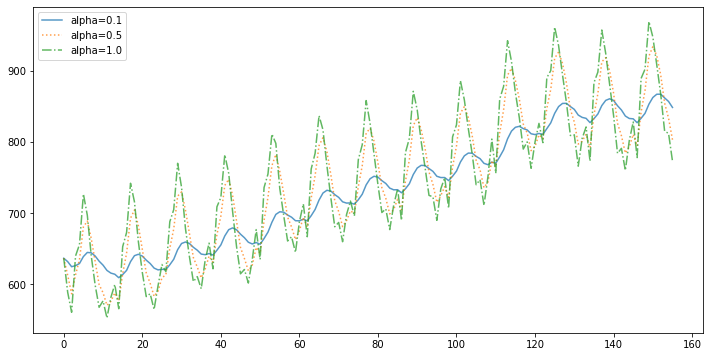

In [11]:
styles = ['-', ':', '-.']
for i, style in zip([best_alpha, 0.5, 1.0], styles):
    plt.plot(results[i][0].fittedvalues, style, label=f'alpha={i}', alpha=0.75)
plt.legend()

In [12]:
# import warnings
# warnings.filterwarnings('ignore')

In [13]:
x_test['ses'] = results[best_alpha][1]

In [14]:
x_train['ses'] = results[best_alpha][0].fittedvalues

In [15]:
x_train.head()

,production,ses
month,,
1962-01-01,589,636.80000
1962-02-01,561,632.02000
1962-03-01,640,624.91800
1962-04-01,656,626.42620
1962-05-01,727,629.38358


In [16]:
x_test.head()

,production,ses
month,,
1975-01-01,834,844.842813
1975-02-01,782,844.842813
1975-03-01,892,844.842813
1975-04-01,903,844.842813
1975-05-01,966,844.842813


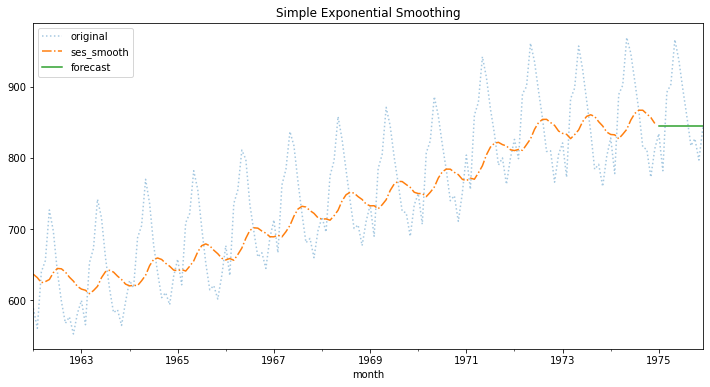

In [17]:
ax = milk.plot(style=':', alpha=0.4, title=r'Simple Exponential Smoothing')
x_train['ses'].plot(style='-.', ax=ax)
x_test['ses'].plot(ax=ax)
plt.legend(['original','ses_smooth', 'forecast'])
plt.show()


**Automated Optimization**

In [18]:
ses = SimpleExpSmoothing(x_train['production'].values,
                        initialization_method='estimated').fit(
                        optimized=True,
                        use_brute=True)
ses.summary()

Dep. Variable:,endog,No. Observations:,156
Model:,SimpleExpSmoothing,SSE,314995.457
Optimized:,True,AIC,1191.231
Trend:,None,BIC,1197.331
Seasonal:,None,AICC,1191.496
Seasonal Periods:,None,Date:,"Tue, 07 Dec 2021"
Box-Cox:,False,Time:,01:04:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9975314,alpha,True
initial_level,588.25764,l.0,True


In [19]:
x_test['ses_auto'] = ses.forecast(12)
x_train['ses_auto'] = ses.fittedvalues

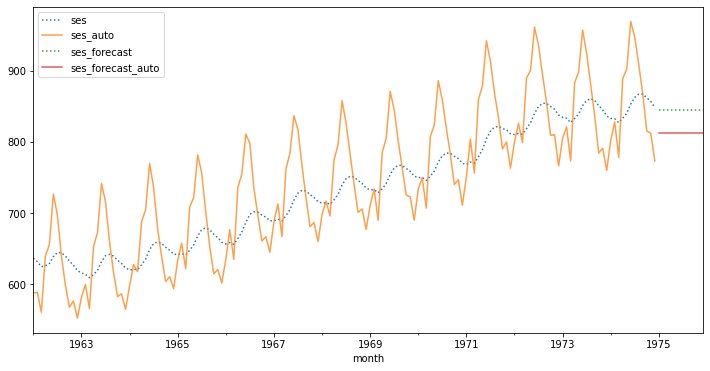

In [20]:
# ax = milk.plot(style=':', alpha=0.4, title=r'SES with $\alpha$ = 0.2')
ax = x_train['ses'].plot(style=':')
x_train['ses_auto'].plot(style='-', alpha=0.75)
x_test['ses'].plot(ax=ax, style=':')
x_test['ses_auto'].plot(ax=ax, style='-', alpha=0.75)
plt.legend(['ses', 'ses_auto', 'ses_forecast', 'ses_forecast_auto'])
plt.show()


## Double/Holt

In [21]:
holt = Holt(x_train['production'].values, 
            initialization_method='estimated',
            damped_trend=True, 
            exponential=True).fit(
                                optimized=True,
                                use_brute=True)
holt.summary()

Dep. Variable:,endog,No. Observations:,156
Model:,Holt,SSE,317390.789
Optimized:,True,AIC,1198.413
Trend:,Multiplicative,BIC,1213.662
Seasonal:,None,AICC,1199.170
Seasonal Periods:,None,Date:,"Tue, 07 Dec 2021"
Box-Cox:,False,Time:,01:05:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.0001000,beta,True


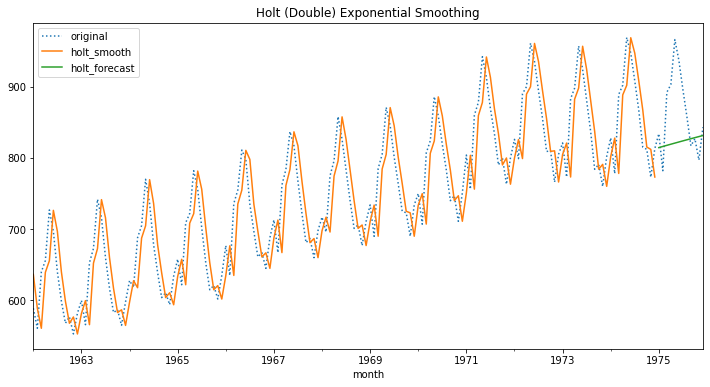

In [22]:
x_test['holt_auto'] = holt.forecast(12)
x_train['holt_auto'] = holt.fittedvalues

ax = milk.plot(style=':', title=r'Holt (Double) Exponential Smoothing')
x_train['holt_auto'].plot(style='-', ax=ax)
x_test['holt_auto'].plot(ax=ax)
plt.legend(['original','holt_smooth', 'holt_forecast'])
plt.show()


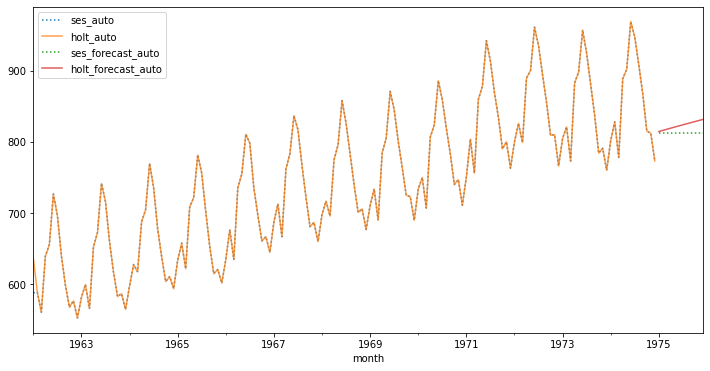

In [23]:
ax = x_train['ses_auto'].plot(style=':')
x_train['holt_auto'].plot(style='-', alpha=0.75) 
x_test['ses_auto'].plot(ax=ax, style=':')
x_test['holt_auto'].plot(ax=ax, style='-', alpha=0.75)
plt.legend(['ses_auto', 'holt_auto', 'ses_forecast_auto', 'holt_forecast_auto'])
plt.show()

## Holt-Winters (Triple Exponential Smoothing)

In [24]:
from itertools import product
trend = ['mul', 'add']
seasonal = ['mul', 'add']
periods = [3, 6, 12]

combos = [i for i in product(*[trend, seasonal, periods])]
combos

[('mul', 'mul', 3),
 ('mul', 'mul', 6),
 ('mul', 'mul', 12),
 ('mul', 'add', 3),
 ('mul', 'add', 6),
 ('mul', 'add', 12),
 ('add', 'mul', 3),
 ('add', 'mul', 6),
 ('add', 'mul', 12),
 ('add', 'add', 3),
 ('add', 'add', 6),
 ('add', 'add', 12)]

In [25]:
from sklearn.model_selection import ParameterGrid
for item in ParameterGrid({'trend': trend, 'seasonal': seasonal, 'periods':periods}):
    print(item)

{'periods': 3, 'seasonal': 'mul', 'trend': 'mul'}
{'periods': 3, 'seasonal': 'mul', 'trend': 'add'}
{'periods': 3, 'seasonal': 'add', 'trend': 'mul'}
{'periods': 3, 'seasonal': 'add', 'trend': 'add'}
{'periods': 6, 'seasonal': 'mul', 'trend': 'mul'}
{'periods': 6, 'seasonal': 'mul', 'trend': 'add'}
{'periods': 6, 'seasonal': 'add', 'trend': 'mul'}
{'periods': 6, 'seasonal': 'add', 'trend': 'add'}
{'periods': 12, 'seasonal': 'mul', 'trend': 'mul'}
{'periods': 12, 'seasonal': 'mul', 'trend': 'add'}
{'periods': 12, 'seasonal': 'add', 'trend': 'mul'}
{'periods': 12, 'seasonal': 'add', 'trend': 'add'}


In [26]:
results = {}
for i, (t, s, p )in enumerate(combos):
    exp = ExponentialSmoothing(x_train['production'].values, 
                           initialization_method='estimated',
                           seasonal_periods=p, 
                           trend=t, 
                           seasonal=s).fit(optimized= True, use_brute = True)
    
    forecast = exp.forecast(12)
    scores = {
        'rmse': rmse(x_test['production'].values, forecast),
        'mape': mape(x_test['production'].values, forecast),
        'rmspe': rmspe(x_test['production'].values, forecast),
        'aic': exp.aic,
        'bic': exp.bic
    }
    results[i+1] = [exp, forecast, scores]

In [27]:
initial_score = results[1][2]['mape']
model = 0
for k,v in results.items():
    if v[2]['mape'] < initial_score:
        initial_score = v[2]['mape']
        model = k
    print(f'for model #{k} RMSPE={v[2]["rmspe"]} RMSE={v[2]["rmse"]} MAPE={v[2]["mape"]} BIC={v[2]["bic"]}')
print(f'Best model: {model} with lowest MAPE score: {initial_score}')

for model #1 RMSPE=0.7139034718437772 RMSE=64.30332421202307 MAPE=0.0632015784783375 BIC=1223.4319478973077
for model #2 RMSPE=0.9489871620253245 RMSE=86.33994674361603 MAPE=0.08213666778125822 BIC=1203.01638200421
for model #3 RMSPE=0.20503801685538944 RMSE=18.642363342163645 MAPE=0.017346393831080897 BIC=715.4901236646411
for model #4 RMSPE=0.8239282254825636 RMSE=76.41990749598845 MAPE=0.0633481032219969 BIC=1222.793089172705
for model #5 RMSPE=0.9647067767147738 RMSE=87.84428549144195 MAPE=0.08299185715827202 BIC=1206.8167023615295
for model #6 RMSPE=0.14033210386645636 RMSE=12.226989490353311 MAPE=0.012452841594356815 BIC=694.7876826500933
for model #7 RMSPE=0.855574369851304 RMSE=79.16254592505456 MAPE=0.06790041878848643 BIC=1221.916910994505
for model #8 RMSPE=1.0329680089123414 RMSE=93.63130869978829 MAPE=0.09039084631474009 BIC=1202.5994158938138
for model #9 RMSPE=0.20004033594782208 RMSE=18.14192035579706 MAPE=0.017109294827243098 BIC=714.8542379756685
for model #10 RMSPE=0

In [28]:
results[12][0].summary()

Dep. Variable:,endog,No. Observations:,156
Model:,ExponentialSmoothing,SSE,7936.332
Optimized:,True,AIC,644.979
Trend:,Additive,BIC,693.776
Seasonal:,Additive,AICC,649.971
Seasonal Periods:,12,Date:,"Tue, 07 Dec 2021"
Box-Cox:,False,Time:,01:05:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6988441,alpha,True
smoothing_trend,2.0289e-06,beta,True


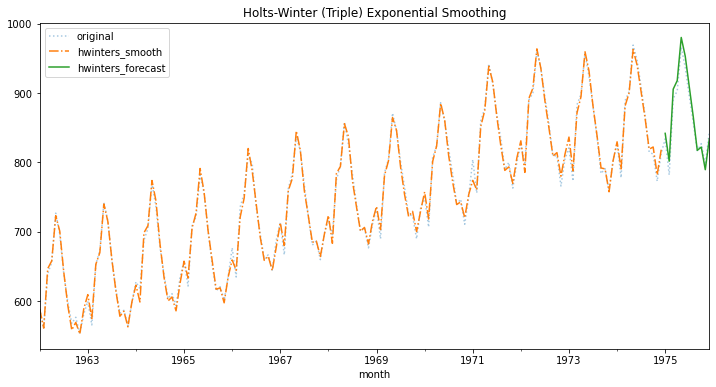

In [29]:
model = results[12][0]
x_test['hwinters'] = model.forecast(12)
x_train['hwinters'] = model.fittedvalues

ax = milk.plot(style=':', alpha=0.4, title=f'Holts-Winter (Triple) Exponential Smoothing')
x_train['hwinters'].plot(style='-.', ax=ax)
x_test['hwinters'].plot(ax=ax)
plt.legend(['original','hwinters_smooth', 'hwinters_forecast'])
plt.show()

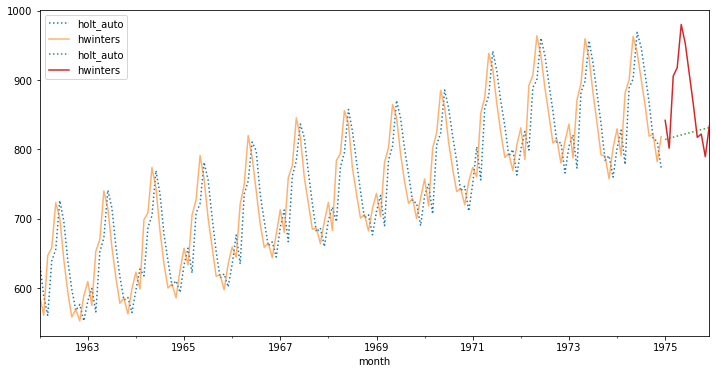

In [30]:
ax = x_train['holt_auto'].plot(style=':')
x_train['hwinters'].plot(ax=ax, style='-', alpha=0.60)
x_test['holt_auto'].plot(ax=ax, style=':')
x_test['hwinters'].plot(ax=ax, style='-')

plt.legend()

**automated**

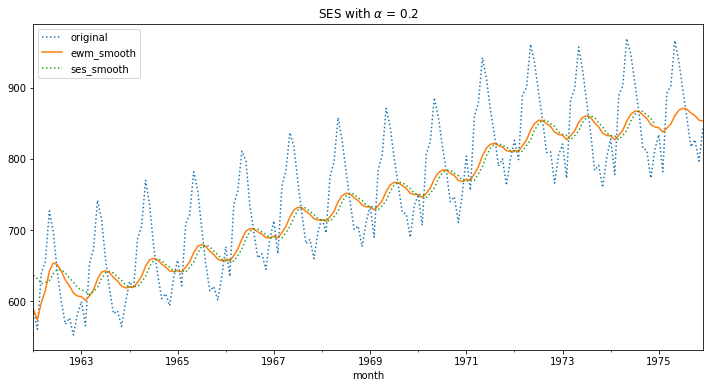

In [31]:
ax = milk.plot(style=':', title=r'SES with $\alpha$ = 0.2')
milk.ewm(alpha=0.1).mean().plot(style='-', ax=ax)
x_train['ses'].plot(ax=ax, style=':')
plt.legend(['original','ewm_smooth', 'ses_smooth'])
plt.show()

In [32]:
exp = ExponentialSmoothing(x_train['production'].values).fit(optimized= True, use_brute = True)
exp.summary()

Dep. Variable:,endog,No. Observations:,156
Model:,ExponentialSmoothing,SSE,314934.000
Optimized:,True,AIC,1191.201
Trend:,None,BIC,1197.301
Seasonal:,None,AICC,1191.466
Seasonal Periods:,None,Date:,"Tue, 07 Dec 2021"
Box-Cox:,False,Time:,01:05:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,589.00000,l.0,True


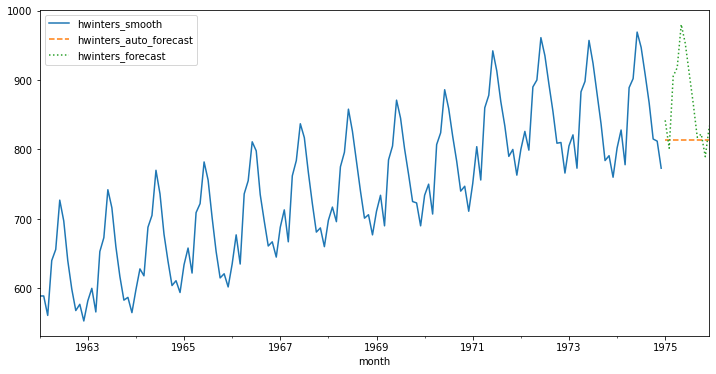

In [33]:
x_train['hwinters_auto'] = exp.fittedvalues
x_test['hwinters_auto'] = exp.forecast(12)
ax = x_train['hwinters_auto'].plot(label='hwinters_smooth')
x_test['hwinters_auto'].plot(ax=ax, label='hwinters_auto_forecast', style='--')
x_test['hwinters'].plot(ax=ax, label='hwinters_forecast', style=':')
plt.legend()

## There is more

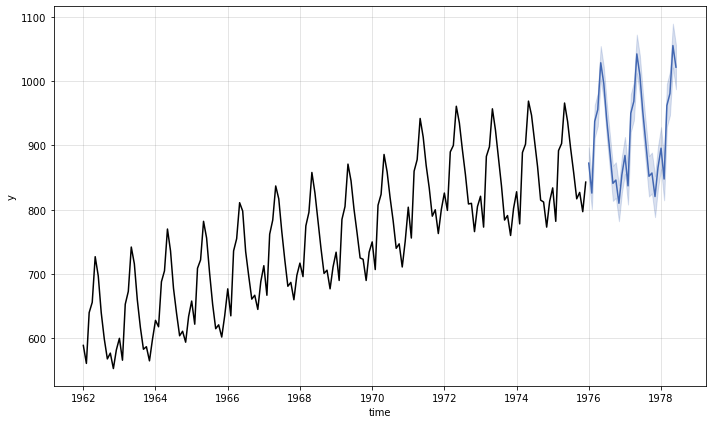

In [39]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
from kats.consts import TimeSeriesData
warnings.simplefilter(action='ignore')

ts = milk.reset_index() 
ts.columns = ['time','value']
ts = TimeSeriesData(ts)

params = HoltWintersParams(
            trend="add",
            damped=True,
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=ts, 
    params=params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

# Building AutoRegressive and Moving Average Models

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA